In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
import cryptography
import yfinance as yf

from efficient_frontier_plot import *

In [30]:
import warnings      # 경고 메시지 차단
warnings.filterwarnings('ignore')

['VOO', 'SCHD', 'TLT', 'EEM', 'IEV', 'SOXX']

['SPY', 'IEV', 'EEM', 'TLT', 'IYR', 'GLD']

1. **VOO** - **Vanguard S&P 500 ETF**  
   미국 S&P 500 지수를 추종하는 ETF로, 미국 대형주에 투자할 수 있는 대표적인 상품입니다.

2. **SCHD** - **Schwab U.S. Dividend Equity ETF**  
   미국 고배당 주식으로 구성된 ETF로, 안정적인 배당 수익을 추구하는 투자자에게 적합합니다.

3. **TLT** - **iShares 20+ Year Treasury Bond ETF**  
   만기 20년 이상의 미국 장기 국채에 투자하는 ETF로, 주로 안정적인 소득과 리스크 분산을 목표로 합니다.

4. **EEM** - **iShares MSCI Emerging Markets ETF**  
   신흥시장 주식에 투자하는 ETF로, 중국, 한국, 브라질 등 다양한 신흥국 주식을 포함합니다.

5. **IEV** - **iShares Europe ETF**  
   유럽 주요국의 대형주에 투자하는 ETF로, MSCI Europe 지수를 추종합니다. 유럽 시장에 직접 투자할 수 있는 수단입니다.

6. **SOXX** - **iShares Semiconductor ETF**  
   반도체 산업을 대표하는 주요 기업들로 구성된 ETF입니다. 반도체 관련 기술주에 집중 투자합니다.

In [31]:
import yfinance as yf
import pandas as pd

# 티커 리스트 설정
tickers = ['VOO', 'SCHD', 'TLT', 'EEM', 'IEV', 'SOXX']

# 데이터 다운로드
all_data = {ticker: yf.download(ticker, start='2019-01-05')['Adj Close'] for ticker in tickers}

# 데이터프레임으로 변환
prices = pd.DataFrame(all_data)

# 월말 가격을 가져와 월간 수익률 계산
df = prices.resample('ME').last().pct_change().dropna()

# 기간 내 월간 수익률 출력
print(df.loc['2019-01-05':'2024-10-31'].head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                 VOO      SCHD       TLT       EEM       IEV      SOXX
Date                                                                  
2019-02-28  0.032499  0.040554 -0.013764 -0.015313  0.031475  0.063988
2019-03-31  0.019256  0.029400  0.055716  0.011310  0.010715  0.034374
2019-04-30  0.040341  0.032135 -0.019911  0.023532  0.037105  0.116176
2019-05-31 -0.063479 -0.075982  0.068392 -0.073298 -0.054889 -0.165627
2019-06-30  0.069912  0.072879  0.009501  0.062078  0.063593  0.128627


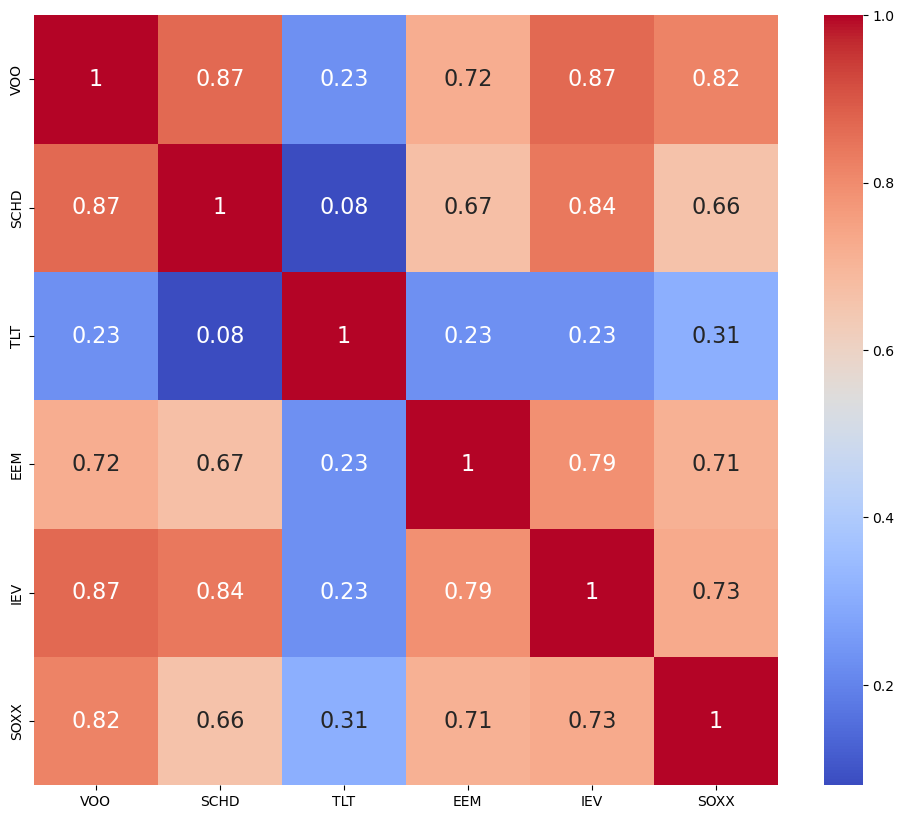

In [32]:
# 상관계수 그래프 

plt.figure(figsize=(12, 10))
sns.heatmap(df.corr().round(2), annot = True, annot_kws = {"size" : 16}, cmap='coolwarm')
plt.show()

공분산과 분산:

공분산 행렬에서 대각선 요소는 각 자산의 자기 자신과의 공분산을 의미하며, 이는 분산을 나타냅니다.
예를 들어, 행렬의 첫 번째 자산에 대한 대각선 값인 0.00949029는 해당 자산의 분산입니다.
공분산 행렬은 일반적으로 분산의 값으로 표현되므로, 1이 아니라 자산의 실제 분산 값이 나타납니다.
상관행렬과의 차이:

상관행렬에서는 각 자산이 자신과의 상관관계가 1로 나타나므로 대각선 요소가 모두 1이 됩니다. 상관행렬은 공분산 행렬을 각 자산의 표준편차로 나눈 값이기 때문에, 자신과의 상관관계가 1로 나타나는 것입니다.
공분산 행렬과 상관행렬의 관계:

공분산 행렬을 상관행렬로 변환하려면, 공분산 행렬의 각 요소를 해당 자산들의 표준편차 곱으로 나누어야 합니다.

In [33]:
covmat= np.array(df.cov()*12)      #  자산별 수익률의 공분산
avg_returns= np.array(df.mean()*12)      #  종목별 기대수익률 
names=tickers
n_assets = len(names)

rf = .02                           # 무위험이자율
weight=np.array(n_assets*[1/n_assets]).T  # 자산별 초기 비중
display(weight,avg_returns,covmat)

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

array([ 0.16866635,  0.17895816, -0.01123835,  0.04269347,  0.09123184,
        0.2936037 ])

array([[0.03010831, 0.02525599, 0.00634991, 0.02224962, 0.02846156,
        0.04180983],
       [0.02525599, 0.02797558, 0.00201827, 0.02017203, 0.0266775 ,
        0.0323148 ],
       [0.00634991, 0.00201827, 0.02473858, 0.00636393, 0.00694819,
        0.01434882],
       [0.02224962, 0.02017203, 0.00636393, 0.03205105, 0.02685084,
        0.03702864],
       [0.02846156, 0.0266775 , 0.00694819, 0.02685084, 0.03578717,
        0.04042117],
       [0.04180983, 0.0323148 , 0.01434882, 0.03702864, 0.04042117,
        0.08598996]])

In [34]:
# 프론티어 구성하는 계산값 구기기

port_result_df = get_efficient_frontier_value(avg_returns, covmat, 50)

port_result_df.head(5)

,0,0,0,1,2,3,4,5
13,0.1184,0.0696,0.0,0.4016,0.5151,0.0833,0.0,0.0
14,0.1185,0.0759,0.0,0.4421,0.5019,0.0560,0.0,0.0
15,0.1189,0.0821,0.0,0.4825,0.4888,0.0287,0.0,0.0
16,0.1195,0.0883,0.0,0.5231,0.4760,0.0009,0.0,0.0
17,0.1205,0.0945,0.0,0.5561,0.4439,0.0000,0.0,0.0


In [35]:
# 프론티어에 필요한 변동성과 기대수익률만 따로 추린다.

port_result=port_result_df.iloc[:,[0,1]]  # 포트폴리오 변동성과 기대수익률
port_result.columns=['portf_vol', 'portf_rtns']

### 효율적 프론티어 구하기

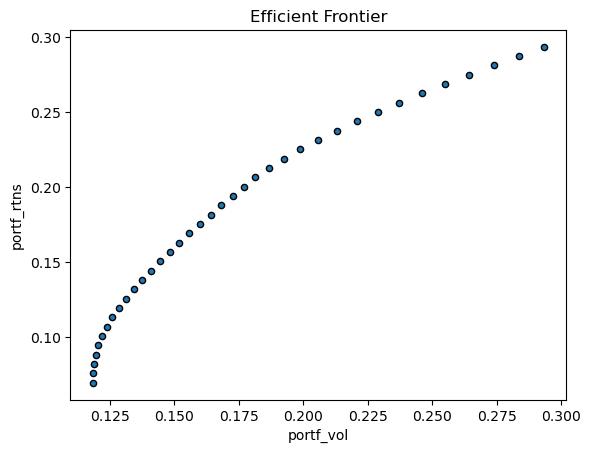

In [36]:
fig, ax = plt.subplots()
port_result.plot(kind='scatter', x='portf_vol', 
                      y='portf_rtns', 
                      cmap='RdYlGn', edgecolors='black', title='Efficient Frontier', 
                      ax=ax)
plt.show()

<Axes: xlabel='portf_rtns'>

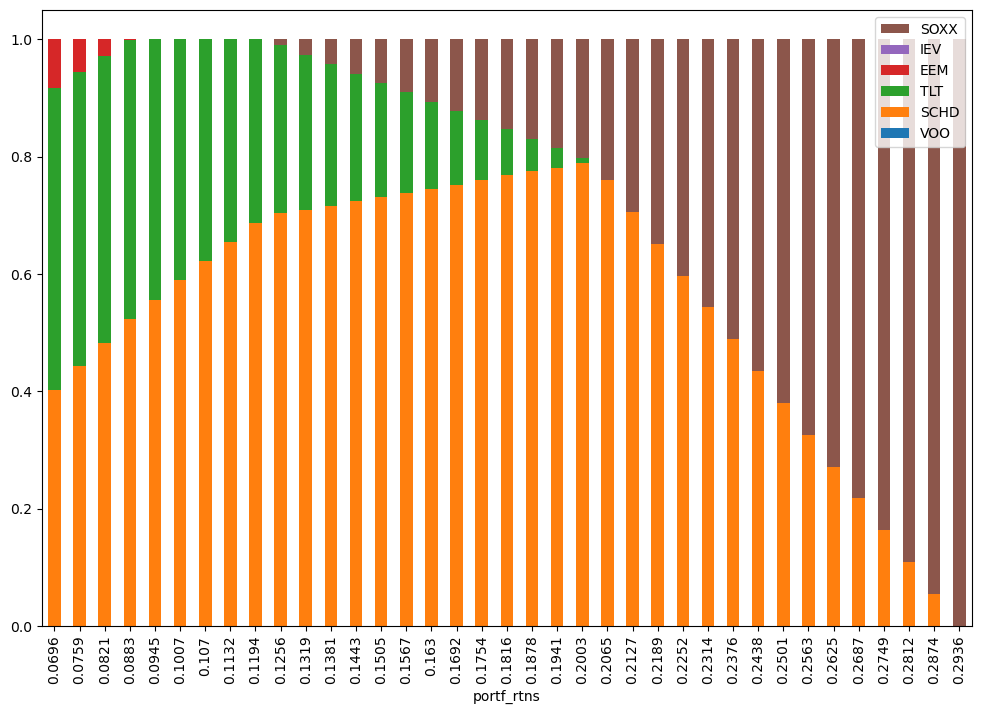

In [37]:
portfolio_weight_df= port_result_df.iloc[:,[2,3,4,5,6,7]]  #  # 효율적 포트폴리오 결과치에서 자산별 비중만 추출
portfolio_weight_df.columns=df.columns  # 자산명 

# 포트폴리오 기대수익률과 자산별 투자비중의 결합
port_all=  pd.concat([portfolio_weight_df, port_result[['portf_rtns']]],axis=1)
opt_port= port_all.set_index('portf_rtns')

# 포트폴리오 기대수익률에 따른 자산별 투자비중 변화 그래프 
opt_port.plot.bar(stacked=True,legend='reverse', figsize=(12,8))

### 1. Minimum Variance  Portfolio = MVP

최소 분산 포트폴리오는 특정 자산군에서 변동성(위험)을 최소화하는 포트폴리오입니다. 기대수익률과 상관없이 전체 포트폴리오의 리스크를 가장 낮게 유지하는 것이 목표입니다. MVP는 각 자산의 수익률, 변동성, 상관관계를 바탕으로 최적의 자산 비중을 계산합니다.

In [38]:
# 포트폴리오 변동성 계산

def get_portf_vol(weight, cov_mat):
    return np.sqrt(np.dot(weight.T, np.dot(cov_mat, weight)))

In [39]:
get_portf_vol(weight,covmat)

0.15909403925433774

In [40]:
# 포트폴리오 변동성 최소화를 위한 최적화 

def minimum_variance_optimization(returns,cov_mat):
    
    num_assets=len(returns) # 자산갯수 
    args=(cov_mat)          # 공분산 입력
    constraints=({'type': 'eq','fun': lambda x: np.sum(x)-1})
    bounds=[(0,1) for i in range(num_assets)]  # 자산별 비중 제약 (0, 1)
    
    result_mv= sco.minimize(get_portf_vol,num_assets*[1./num_assets],args=args, method='SLSQP',
                         bounds=bounds,constraints=constraints)
    MVO_Allocation =pd.DataFrame(result_mv.x,index=df.columns,columns=['allocation'])  # 종목명 인덱스만 가져다 쓴다.
    
    return round(MVO_Allocation*100,2)


      allocation
VOO         0.00
SCHD       40.68
TLT        51.38
EEM         7.94
IEV         0.00
SOXX        0.00


<Axes: >

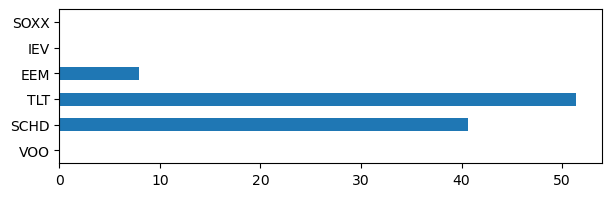

In [41]:
# 함수 결과값 확인

MVO =minimum_variance_optimization(avg_returns,covmat)
print(MVO)
MVO.plot.barh(figsize=(7, 2), legend=False)


### 2. Maximum Sharpe Ratio Portfolio(최대 샤프비율 포트폴리오)
        = Tangent Portfolio

최대샤프지수 포트폴리오(Maximum Sharpe Ratio Portfolio)란 샤프지수가 최대가 되도록 하는 포트폴리오를 구성하는 것이다. 샤프지수는 $\frac{R_p-R_f}{\sigma_p}$, 즉 포트폴리오의 수익을 변동성으로 나눈 값이며, 위험 대비 수익률이라고도 볼 수 있다. 따라서 샤프지수가 최대가 되는 포트폴리오는 위험은 낮으면서 수익은 높은 포트폴리오를 말한다. 

In [42]:
# 목적함수인 (-) 샤프비율을 구하는 함수 

def sharpe_ratio(weight,returns,cov_mat,rf):
    ret=np.sum(returns*weight)                            #  포트폴리오 기대수익률 
    std=np.sqrt(np.dot(weight.T,np.dot(cov_mat,weight)))   # 포트폴리오 리스크 (변동성)
    sharpe =-(ret-rf)/std                                 # 최소화--> 최대화 되므로 마이너스 붙인다.
    return sharpe
    
# 함수 결과 값 확인하기
gg= sharpe_ratio(weight,avg_returns,covmat,0.02)
print(gg)


-0.6745645379630671


In [43]:
# (-)샤프비율을 최소화하기 위한 최적화 함수  = (+) 샤프비율을 최대화

def mean_variance_optimization(returns,cov_mat,rf):  # ( 포트폴리오 기대수익률, 공분산, 무위험이자율)
    
    num_assets=len(returns)
    args=(returns,cov_mat,rf)
    constraints=({'type': 'eq','fun': lambda x: np.sum(x)-1})
    bounds=[(0,1) for i in range(num_assets)]
    
    result= sco.minimize(sharpe_ratio,num_assets*[1./num_assets,],args=args, method='SLSQP',
                         bounds=bounds,constraints=constraints)
    Sharp_Allocation =pd.DataFrame(result.x,index=df.columns,columns=['allocation'])  # 종목명 인덱스만 가져다 쓴다.
    
    return round(Sharp_Allocation*100,2)  

      allocation
VOO         0.00
SCHD       65.68
TLT         0.00
EEM         0.00
IEV         0.00
SOXX       34.32


<Axes: >

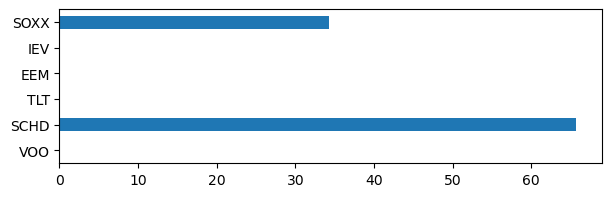

In [44]:
# 함수 결과값  그래프 확인하기

sharp = mean_variance_optimization(avg_returns,covmat,rf)
print(sharp)
sharp.plot.barh(figsize=(7, 2), legend=False)

### 3. Risk parity portfolio (위험균형 포트폴리오)


포트폴리오를 구성하는 자산들과 전체 위험의 관계를 이해하기 위해서는, 먼저 한계 위험기여도(MRC: Marginal Risk Contribution)와 위험기여도(RC: Risk Contribution)에 대해 알아야 한다. 한계 위험기여도는 특정 자산의 비중을 한 단위 증가시켰을 때 전체 포트폴리오 위험의 증가를 나타내는 단위로서, 수학의 편미분과 같은 개념이다. $i$번째 자산의 한계 위험기여도는 아래와 같이 나타낼 수 있다.

$$MRC_i = \frac{\partial\sigma_p}{\partial w_i} $$

$\sqrt {f'(x)} = \frac{f'(x)}{2\sqrt{f(x)}}$인 사실을 이용하면, 한계 위험기여도는 다음과 같이 풀 수 있다. 결과적으로 분자는 분산-공분산 행렬과 각 자산의 비중의 곱, 분모는 포트폴리오의 표준편차 형태로 나타난다.

$$
\begin{equation} 
\begin{split}
\frac{\partial\sigma_p}{\partial w} & = \frac{\partial(\sqrt{w'\Omega w})}{\partial w} \\
& =\frac{\partial(w'\Omega w)}{\partial w} \times \frac{1}{2\sqrt{w'\Omega w}} \\
& =\frac{2\Omega w}{2\sqrt{w'\Omega w}} \\
& =\frac{\Omega w}{\sqrt{w'\Omega w}}
\end{split}
\end{equation} 
$$

위험기여도는 특정 자산이 포트폴리오 내에서 차지하는 위험의 비중이다. 한계 위험기여도가 큰 자산도 포트폴리오 내에서 비중이 작다면, 포트폴리오 내에서 차지하는 위험의 비중은 작을 것이다. 반면에, 한계 위험기여도가 작은 자산일지라도 비중이 압도적으로 많다면, 포트폴리오 내에서 차지하는 위험의 비중은 클 것이다. 결과적으로 $i$번째 자산의 위험기여도는, $i$번째 자산의 한계 위험기여도와 포트폴리오 내 비중의 곱으로 이루어진다.

$$RC_i = \frac{\partial\sigma_p}{\partial w_i} \times w_i$$

특정 자산이 포트폴리오의 위험을 대부분 차지하는 문제를 막고, 모든 자산이 동일한 위험기여도를 가지는 포트폴리오가 위험균형 포트폴리오(Risk Parity Portfolio) 혹은 동일 위험기여도 포트폴리오(Equal Risk Contribution Portfolio)다. 이를 수식으로 쓰면 다음과 같습니다.

$$RC_1 = RC_2 = \dots = RC_n$$
$$\frac{\partial\sigma_p}{\partial w_1} \times w_1 = \frac{\partial\sigma_p}{\partial w_2} \times w_2
= \dots = \frac{\partial\sigma_p}{\partial w_n} \times w_n = \frac{\sigma_p}{n}$$

In [45]:
# 자산별 리스크 기여도를 구하기 위한 함수

def Risk_Contribution(weight,cov_mat) :
    # weight =np.array(weight)
    std=np.sqrt(np.dot(weight.T,np.dot(cov_mat,weight)))  # 포트폴리오 리스크 (변동성)
    mrc=np.dot(cov_mat,weight)/std                        # 한계기여도 = (공분산*자산별 비중)/포트폴리오 리스크
    rc=weight*mrc
    return rc, std

In [46]:
# 리스크 기여도 함수 결과 값 확인하기
rcc=Risk_Contribution(weight,covmat) 
print(rcc)

(array([0.02692943, 0.02346868, 0.01061002, 0.02526739, 0.02883453,
       0.04398398]), 0.15909403925433774)


In [47]:
def risk_parity_target(weight) :
    
    rc,std=Risk_Contribution(weight,covmat)
    RC_assets=rc
    RC_target=std/len(rc)
    objective_fun=np.sum(np.square(RC_assets-RC_target.T))
    
    return objective_fun

In [48]:
# 타깃 함수 결과값 확인하기

op=risk_parity_target(weight)
print(op)

0.0005745220394176402


In [49]:
# 포트폴리오의 자산별 리스크 기여도를 동일하게 하는 자산별 비중

def risk_parity_optimization(cov_matrix):
    
    TOLERANCE= 1e-20
    num_assets=len(cov_matrix)
    constraints=({'type': 'eq','fun': lambda x: np.sum(x)-1.0},{'type': 'ineq','fun': lambda x: x})  
    result=sco.minimize(risk_parity_target,num_assets*[1./num_assets,],method='SLSQP',
                       constraints=constraints, tol=TOLERANCE)    
    RP_Allocation=pd.DataFrame(result.x,index=df.columns,columns=['allocation'])
 
    return  round(RP_Allocation*100,2)              

      allocation
VOO        15.03
SCHD       17.35
TLT        28.48
EEM        15.87
IEV        13.91
SOXX        9.36


<Axes: >

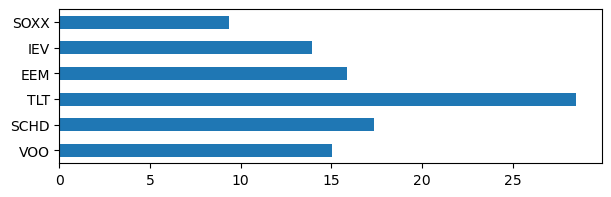

In [50]:
# 함수 결과 값 확인하기

RP= risk_parity_optimization(covmat)
print(RP)
RP.plot.barh(figsize=(7, 2), legend=False)

### 4. Maximum Diversification  (최대분산 포트폴리오)

포트폴리오 분산비율( 자산별 비중가중한 변동성 /포트폴리오 변동성))을 최대화하는 자산별 비중을 구한다. 

여기서 최대분산 포트폴리오란, 포트폴리오의 다양성을 최대화하여 동일한 변동성에서 더 안정적인 포트폴리오를 구성하는 것을 의미한다.

여기서 분자>분모 이므로 상관관계가 낮은 자산으로 포트폴리오를 구성할수록 
분모가 분자에 가까와져 분산비율은 1에 가까워지게 됨.

In [51]:
def diversification_ratio(weight, cov_mat):
    # 개별 자산의 가중 변동성 계산
    # cov_mat의 대각선 요소 (개별 자산 분산)에서 제곱근을 취해 표준편차로 변환하고, 자산 비중(weight)을 곱해 가중 변동성을 계산합니다.
    w_vol = np.dot(np.sqrt(np.diag(cov_mat)), weight.T)  
    
    # 포트폴리오 전체 변동성 계산
    # 비중(weight)와 공분산 행렬(cov_mat)을 사용하여 포트폴리오의 전체 변동성을 계산합니다.
    port_vol = np.sqrt(weight.T @ cov_mat @ weight)       
    
    # 다양화 비율 계산: 개별 자산의 가중 변동성 / 포트폴리오 변동성
    diversification_ratio = w_vol / port_vol
    
    # 다양화 비율을 최대화하기 위해 -1을 곱해 반환 (최적화에서는 음수 반환을 최소화하여 최대화 효과를 얻음)
    return -diversification_ratio

In [52]:
def Most_Diversified(cov_mat, lb, ub):
    # 초기 자산 비중 설정 (각 자산에 동일한 비중으로 초기화)
    x0 = np.repeat(1 / cov_mat.shape[1], cov_mat.shape[1]) 

    # 하단 및 상단 비중 경계 설정
    lbound = np.repeat(lb, cov_mat.shape[1])  # 예: [0, 0, ..., 0]
    ubound = np.repeat(ub, cov_mat.shape[1])  # 예: [1, 1, ..., 1]
    bnds = tuple(zip(lbound, ubound))         # ((0,1), (0,1), ..., (0,1))
    
    # 제약 조건 설정 - 모든 자산의 비중 합이 1이어야 함
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1.0})
           
    # 최적화 옵션 설정 - 허용 오차와 최대 반복 횟수 지정
    options = {'ftol': 1e-20, 'maxiter': 800}   # 허용 수준, 최대 반복 횟수

    # 최적화 실행 - 다양화 비율을 최대화하는 자산 비중 구하기
    result = sco.minimize(
        fun=diversification_ratio,   # 다양화 비율을 계산하는 함수
        x0=x0,                       # 초기 비중 값
        args=cov_mat,                # 공분산 행렬 전달
        method='SLSQP',              # SLSQP 최적화 방법 사용
        constraints=constraints,     # 제약 조건 (비중 합 = 1)
        options=options,             # 최적화 옵션 (허용 수준, 반복 횟수 등)
        bounds=bnds                  # 비중 경계 (각 자산 0 ~ 1 사이)
    )
    
    # 결과를 데이터프레임으로 정리하여 반환 (비중을 백분율로 반올림)
    MD_Allocation = pd.DataFrame(result.x, index=df.columns, columns=['allocation'])
    
    return round(MD_Allocation * 100, 2)   # 백분율로 표현된 자산 비중 반환

      allocation
VOO         0.00
SCHD       36.08
TLT        47.67
EEM        14.03
IEV         0.00
SOXX        2.22


<Axes: >

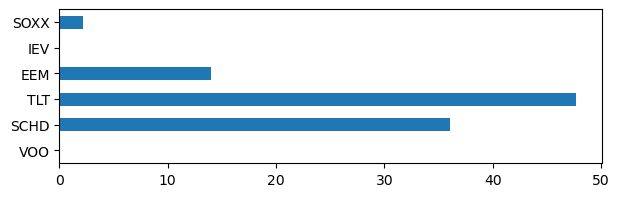

In [53]:
# 함수 결과 값 확인하기

MD= Most_Diversified(covmat,0.0,1.0)
print(MD)
MD.plot.barh(figsize=(7, 2), legend=False)